# Ge - Visão Computacional
# Alunos: 
Leila Biggi e Lucas Heron

## Importações e úteis

In [23]:
import cv2
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [11]:
def show_images(images, titles = None):
  n = len(images)
  plt.figure(figsize=(20, 10))
  for i in range(n):
    plt.subplot(1, n, i + 1)
    plt.imshow(images[i])
    if titles is not None:
      plt.title(titles[i])
    plt.axis('off')
  plt.show()

## Pré-processamento

In [12]:
healthy = '../Test/Healthy/'
powdery = '../Test/Powdery/'
rust = '../Test/Rust/'


healthy_images = [(os.path.join(healthy, f), 0) for f in os.listdir(healthy) if f.endswith('.jpg')]
powdery_images = [(os.path.join(powdery, f), 1) for f in os.listdir(powdery) if f.endswith('.jpg')]
rust_images = [(os.path.join(rust, f), 2) for f in os.listdir(rust) if f.endswith('.jpg')]

all_images = healthy_images + powdery_images + rust_images

df = pd.DataFrame(all_images, columns=['image_path', 'label'])

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [13]:
df.to_csv('../Test/plant_disease.csv', index=False)

In [14]:
df.head()

,image_path,label
0,../Test/Powdery/9e0ba1619bdf4943.jpg,1
1,../Test/Healthy/8ddd5ec1c0de38c4.jpg,0
2,../Test/Rust/91a12f3a425635ef.jpg,2
3,../Test/Powdery/83b96c056477bf11.jpg,1
4,../Test/Powdery/83d867d86f14c62b.jpg,1


In [15]:
healthy_img_example = cv2.imread(df['image_path'][1], cv2.IMREAD_COLOR_RGB)
powdery_img_example = cv2.imread(df['image_path'][0], cv2.IMREAD_COLOR_RGB)
rust_img_example = cv2.imread(df['image_path'][2], cv2.IMREAD_COLOR_RGB)

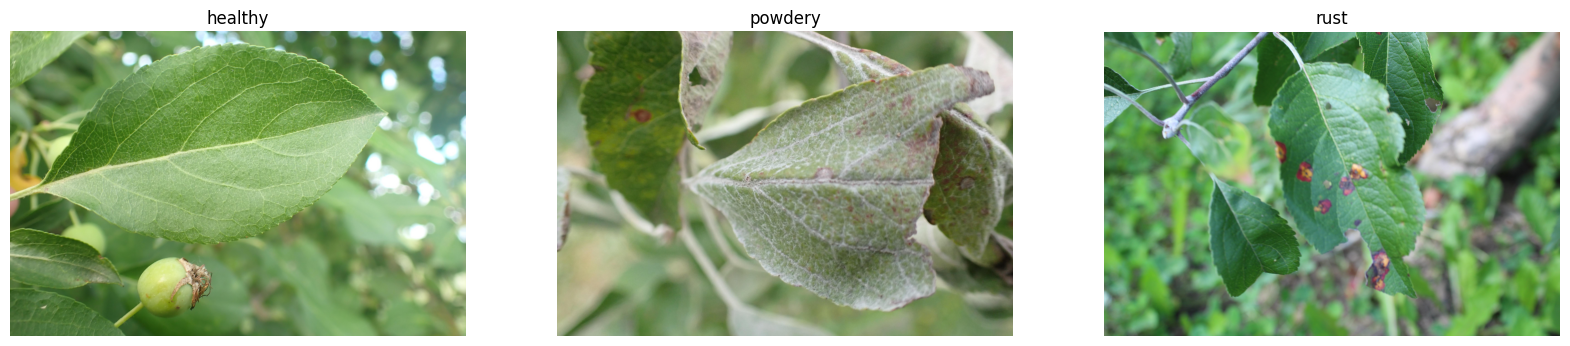

In [16]:
show_images([healthy_img_example, powdery_img_example, rust_img_example], ['healthy', 'powdery', 'rust'])

## Segmentação da imagem por cor

In [ ]:
os.makedirs('../Test/total/', exist_ok=True)
for i in range(len(df)):
    img_path = df.iloc[i]['image_path']
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    
    # img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    image_name = os.path.basename(img_path)
    
    output_path = f'../Test/total/{image_name}'
    
    cv2.imwrite(output_path, img)

In [ ]:
def color_segmentation(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    result = image.copy()
    
    lower_green = np.array([35, 40, 40])
    upper_green = np.array([85, 255, 255])
    green_mask = cv2.inRange(hsv, lower_green, upper_green)
    
    lower_powdery = np.array([0, 0, 150])
    upper_powdery = np.array([180, 50, 255])
    powdery_mask = cv2.inRange(hsv, lower_powdery, upper_powdery)
    result[powdery_mask > 0] = [255, 0, 0]  

    lower_rust1 = np.array([0, 50, 50])
    upper_rust1 = np.array([15, 255, 255])
    lower_rust2 = np.array([160, 50, 50])
    upper_rust2 = np.array([180, 255, 255])
    rust_mask = cv2.bitwise_or(cv2.inRange(hsv, lower_rust1, upper_rust1),
                              cv2.inRange(hsv, lower_rust2, upper_rust2))
    result[rust_mask > 0] = [0, 0, 255] 
    
    lower_dead = np.array([10, 50, 20])
    upper_dead = np.array([25, 255, 100])
    dead_mask = cv2.inRange(hsv, lower_dead, upper_dead)
    result[dead_mask > 0] = [0, 255, 255]
    
    return result

In [37]:
os.makedirs('../Test/segmented/', exist_ok=True)
for i in range(len(df)):
    image_name = os.path.basename(df.iloc[i]['image_path'])
    
    img_path = f'../Test/total/{image_name}'
    
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    
    
    segmented_img = color_segmentation(img)

    output_path = f'../Test/segmented/{image_name}'

    cv2.imwrite(output_path, segmented_img)